# 第4章 画像処理と畳み込みニューラルネット - 1

## 4.1 画像と畳み込み計算
* 画像分野における畳み込み：画像に対してある小さなカーネル行列を移動させながら各要素の積の和を取る
* カーネルの係数を変えることで、平滑化やエッジの抽出などができる
* 画像からカーネルを使用して特徴量を抽出しているともいえる
* 異なるカーネルをあらかじめ複数用意して特徴寮を抽出し、分類に使用することも考えられる
* CNNのベースのアイデア：カーネルの各係数を学習し、自動で分類などに重要な特徴寮を抽出しよう
* 畳み込み計算：ようは線形結合（つまり微分可能）なので、勾配降下法で学習できる

## 4.2 CNNによる画像分類
* CNNによる画像分類：畳み込み -> 活性化関数を複数回行う
* 画像データ：(C, H, W)の形で保持される
* H, W: 画像の縦と横のサイズ、C: 色数またはチャンネル
  * RGBだとC = 3, グレースケールだとC = 1
* 最終的にはCは最後の畳み込み層のカーネル数になる
* この処理によって得られた特徴量をMLPに入れて最終的なクラス判別を行う
* プーリング：畳み込みの後に位置の感度を鈍くする

### 4.2.1 Fashion-MNIST
* MNIST: 28x28ピクセルのモノクロ手書き数字データセット（画像分類の代表的なベンチマーク）
* Fashion-MNIST: 10カテゴリの洋服の画像のデータセット（MNISTより分類が難しい）
* torchvisionを使って簡単にFashon-MNISTを利用できる

In [1]:
%matplotlib inline
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# loggerを使う
from logging import getLogger, StreamHandler, Formatter

# create logger
logger = getLogger(__name__)
log_fmt = Formatter("%(asctime)s %(name)s %(lineno)s [%(levelname)s][%(funcName)s] %(message)s")

# ログレベル設定
log_level = "INFO"
#log_level = "DEBUG"
logger.setLevel(log_level)

# handlerの生成
handler = StreamHandler()
handler.setLevel(log_level)
handler.setFormatter(log_fmt)
logger.addHandler(handler)

In [3]:
# gpuを使えるときはgpuを使う
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# trainデータを取得
# そのままだとPILの画像形式でDatasetを作ってしまうので、transforms.ToTensorでTensorに変換してから利用する
fashion_mnist_train = FashionMNIST("./data/FashionMNIST", train=True, download=True, transform=transforms.ToTensor())

# testデータの取得
fashion_mnist_test = FashionMNIST("./data/FashionMNIST", train=False, download=True, transform=transforms.ToTensor())

In [5]:
# 確認
logger.info(f"length: {len(fashion_mnist_train)}") # データ数
logger.info(f"shape : {fashion_mnist_train[0][0].shape}") # datasetの0番目のdata. (C, H, W)の形になっている
logger.info(f"label : {fashion_mnist_train[0][1]}") # datasetの0番目のdataに対応する正解ラベル
logger.info(f"length: {len(fashion_mnist_test)}")
logger.info(f"shape : {fashion_mnist_test[1][0].shape}")
logger.info(f"label : {fashion_mnist_test[1][1]}")

2020-05-05 21:40:56,256 __main__ 2 [INFO][<module>] length: 60000
2020-05-05 21:40:56,258 __main__ 3 [INFO][<module>] shape : torch.Size([1, 28, 28])
2020-05-05 21:40:56,259 __main__ 4 [INFO][<module>] label : 9
2020-05-05 21:40:56,260 __main__ 5 [INFO][<module>] length: 10000
2020-05-05 21:40:56,263 __main__ 6 [INFO][<module>] shape : torch.Size([1, 28, 28])
2020-05-05 21:40:56,264 __main__ 7 [INFO][<module>] label : 2


In [6]:
# バッチサイズが128のDataLoaderをそれぞれ作成
batch_size = 128
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

### 4.2.2 CNNの構築と学習
* nn.Conv2d: 画像の畳み込みを行う。畳み込みのフィルタを移動させることで特徴マップを作る
* nn.MaxPool2d: プーリングを行う。プーリング領域内の最大値を取り出して出力し特徴マップを簡素化する
* pytorchではnn.Linearは入力の次元を指定する
  * 畳み込みやプーリングによって最終的にどのように画像のサイズが変わるのか事前に計算する必要がある

**2層の畳み込み + 2層のMLPをつなげたCNNの実装**
* Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
* MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
  * in_channels: 入力データのチャンネル数
  * out_channels: 出力データのチャンネル数（≒畳み込みフィルタの数）
  * kernel_size: 畳み込みのフィルタやプーリング領域といった小領域（カーネル）の一辺のサイズ
  * stride: カーネルの動く際のステップ
  * padding: 入力の周りに「枠」を付けることで出力サイズを調整する
  * dilation: カーネルにあける隙間の大きさ

In [7]:
# (N, C, H, W)形式のTensorを(N, C*H*W)に引き延ばす層
# 畳み込み層の出力をMLPに渡す際に必要
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1) # -1を渡すとサイズ数を自動で調整する

# 5x5のカーネルを使用し、最初に32個、次に64個のチャンネルを作成する
# BatchNorm2dは画像形式用のBatch Normalization
# Rdroput2dは画像形式用のDropout
# 最後にFlatterLayerを挟む
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5), # 引数は順に、in_channels, out_channels, kernel_size
    nn.MaxPool2d(2), # ReLUのあとにプーリングするのでは...？
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
).to(device)

In [8]:
# 畳み込みによって最終的にどのようなサイズになっているかを実際にデータを入れて確認
# ここで得られた出力サイズがMLPの入力になる
test_input = torch.ones([1, 1, 28, 28]).to(device) # 全要素が1のtensor
print(conv_net(test_input).size())
conv_output_size = conv_net(test_input).size()[-1]

torch.Size([1, 1024])


In [9]:
# 2層のMLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200), # 畳み込みの出力サイズが入力になる
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
).to(device)

# 最終的なCNN
net = nn.Sequential(
    conv_net,
    mlp
).to(device)

In [10]:
def eval_net(net, data_loader, device):
    """
    評価のヘルパー関数
    """
    # 初期化
    net.to(device).eval()
    ys = []
    ypreds = []
    
    for x, y in data_loader:
        # gpuを使う場合の処理
        x = x.to(device)
        y = y.to(device)

        # 確率が最大のクラスを予測
        _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
        
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)

    # 予測精度(accuracy)を計算
    acc = (ys == ypreds).float().sum() / len(ys)
    
    return acc.item()

In [11]:
def train_net(net, train_loader, test_loader, device, optimizer_cls=optim.Adam
              , loss_fn=nn.CrossEntropyLoss(), n_iter=10):
    """
    学習のヘルパー関数
    """
    # 初期化
    net.to(device).train()
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    
    for epoch in tqdm(range(n_iter)):
        # 初期化
        running_loss = 0.0
        n = 0
        n_acc = 0
        
        for i, (x, y) in enumerate(train_loader):
            # gpuを使う場合の処理
            x = x.to(device)
            y = y.to(device)
            
            h = net(x)
            loss = loss_fn(h, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            n += len(x)
            _, y_pred = h.max(1)
            n_acc += (y == y_pred).float().sum().item()
            
        train_losses.append(running_loss / i)

        # 学習データの予測精度
        train_acc.append(n_acc / n)

        # テストデータの予測精度
        val_acc.append(eval_net(net, test_loader, device))

        # このepochでの結果を表示
        #print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
        logger.debug(f"epoch: {epoch}")
        logger.debug(f"train_losses: {train_losses[-1]}")
        logger.debug(f"train_acc: {train_acc[-1]}")
        logger.debug(f"val_acc: {val_acc[-1]}")
        
    return train_losses, train_acc, val_acc

In [12]:
# 実行（cpuだと時間がかかる）
train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, device, n_iter=15)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:16<00:00,  9.11s/it]


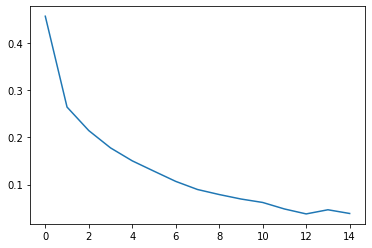

In [13]:
# 確認
plt.plot(train_losses)

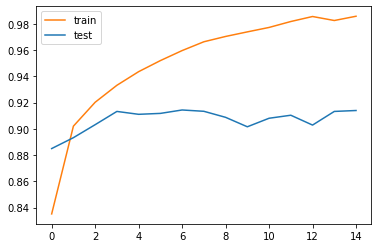

In [14]:
# 確認
plt.plot(train_acc, color="tab:orange", label="train")
plt.plot(val_acc, color="tab:blue", label="test")
plt.legend()

## 4.3 転移学習
* CNNは様々な構造が提案されている（VGG, Inception, ResNet）が、パラメータが多い
* 過学習せずにパラメータを最適化するには学習用の画像（とアノテーション）が大量に必要 + 最適化に時間もかかる
* 転移学習：あるタスクで得られたモデルを他のタスクに転送する技術
* 画像認識においては、一番最後の出力の線形層のみ自分のデータについて学習し直すことでうまくいく（経験則）
* ImageNet（汎用データセット）で事前に学習したResNetなどのパラメータが公開されているので転移学習に適している

### 4.3.1 データの準備
* 転移学習によるタコスとブリトーの分類
* ディレクトリ構成を下記のようにしておくと、torchvision.ImageFolderで読み込んで簡単にDatasetに変換できる
  * Train/
    * buritto/
    * taco/
  * test/
    * burrito/
    * taco/
* pytorchのImageNetによる学習済みモデルは224x224の画像を入力として受け取る
* trainデータはより堅牢な学習結果にするためにRandomCropし、testデータはCenterCropする

In [15]:
from torchvision.datasets import ImageFolder

# ImageFolder関数を使用してDatasetを作成
train_imgs = ImageFolder(
    "./data/taco_and_burrito/train/",
    transform=transforms.Compose([transforms.RandomCrop(224), transforms.ToTensor()])
)
test_imgs = ImageFolder(
    "./data/taco_and_burrito/test/",
    transform=transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
)

# DataLoaderを作成
train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=32, shuffle=False)

In [16]:
# 確認
logger.info(f"label index: {train_imgs.class_to_idx}") # ラベルのインデックス
logger.info(f"length: {len(train_imgs)}") # データ数
logger.info(f"shape : {train_imgs[0][0].shape}") # 1つ目のデータの次元
logger.info(f"label : {train_imgs[0][1]}") # 1つ目のデータの正解ラベル
logger.info(f"length: {len(test_imgs)}") # データ数
logger.info(f"shape : {test_imgs[0][0].shape}") # 1つ目のデータの次元
logger.info(f"label : {test_imgs[0][1]}") # 1つ目のデータの正解ラベル

2020-05-05 21:43:17,538 __main__ 2 [INFO][<module>] label index: {'burrito': 0, 'taco': 1}
2020-05-05 21:43:17,539 __main__ 3 [INFO][<module>] length: 712
2020-05-05 21:43:17,559 __main__ 4 [INFO][<module>] shape : torch.Size([3, 224, 224])
2020-05-05 21:43:17,564 __main__ 5 [INFO][<module>] label : 0
2020-05-05 21:43:17,565 __main__ 6 [INFO][<module>] length: 60
2020-05-05 21:43:17,569 __main__ 7 [INFO][<module>] shape : torch.Size([3, 224, 224])
2020-05-05 21:43:17,573 __main__ 8 [INFO][<module>] label : 0


### 4.3.2 pytorchで転移学習
* 事前学習済みのモデルをロード(ResNet18)
* すべてのパラメータを微分対象から外し、最後の線形層(fc)に新しい線形層をセット
  * 今回は2クラス分類なので線形層の出力次元は2
  * 最後の線形層のみが微分対象になる（学習のし直し）

In [17]:
from torchvision import models

# 事前学習済みのresnet18をロード
net = models.resnet18(pretrained=True)

# 全てのパラメータを微分対象外にする
for p in net.parameters():
    p.requires_grad = False

# 最後の線形層を付け替える
fc_input_dim = net.fc.in_features # 入力の次元数を取得
logger.debug(f"input dim: {fc_input_dim}")
net.fc = nn.Linear(fc_input_dim, 2)

In [18]:
def eval_net(net, data_loader, device):
    """
    これまでとおなじ
    """
    # 初期化
    net.to(device).eval()
    ys = []
    ypreds = []
    
    for x, y in data_loader:
        # gpuを使う場合の処理
        x = x.to(device)
        y = y.to(device)

        # 確率が最大のクラスを予測
        _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
        
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)

    # 予測精度(accuracy)を計算
    acc = (ys == ypreds).float().sum() / len(ys)
    
    return acc.item()

In [19]:
def train_net(net, train_loader, test_loader, device, only_fc=True
              , optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(), n_iter=10):
    # 初期化
    net.to(device).train()
    train_losses = []
    train_acc = []
    val_acc = []
    
    if only_fc:
        # 最後の線形層のパラメータのみをoptimizerに渡す
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    
    for epoch in tqdm(range(n_iter)):
        """
        以降は同じ
        """
        # 初期化
        running_loss = 0.0
        n = 0
        n_acc = 0
        
        for i, (x, y) in enumerate(train_loader):
            # gpuを使う場合の処理
            x = x.to(device)
            y = y.to(device)
            # 確認用
            logger.debug(f"x.shape: {x.shape}")
            logger.debug(f"y.shape: {y.shape}")
            
            h = net(x)
            loss = loss_fn(h, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            n += len(x)
            _, y_pred = h.max(1)
            n_acc += (y == y_pred).float().sum().item()
            
        train_losses.append(running_loss / i)

        # 学習データの予測精度
        train_acc.append(n_acc / n)

        # テストデータの予測精度
        val_acc.append(eval_net(net, test_loader, device))

        # このepochでの結果を表示
        #print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
        logger.debug(f"epoch: {epoch}")
        logger.debug(f"train_losses: {train_losses[-1]}")
        logger.debug(f"train_acc: {train_acc[-1]}")
        logger.debug(f"val_acc: {val_acc[-1]}")
        
    return train_losses, train_acc, val_acc

In [20]:
# 実行（cpuだと時間がかかる）
train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, device, n_iter=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


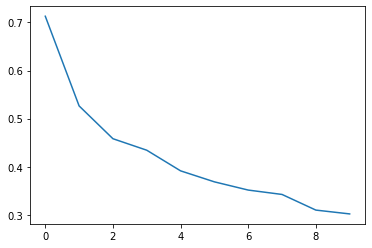

In [21]:
# 確認
plt.plot(train_losses)

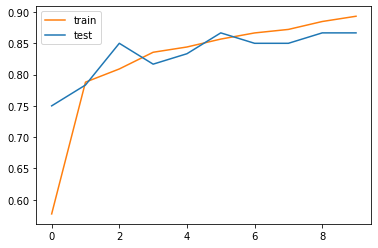

In [22]:
# 確認
# 後半は過学習気味？
plt.plot(train_acc, color="tab:orange", label="train")
plt.plot(val_acc, color="tab:blue", label="test")
plt.legend()

#### 補足
* fc層以外はパラメータが変化せず、毎回同じ計算をやることになる
* fc層を除去したネットワークを事前に計算してそれを入力とするロジスティック回帰モデルを作ってもよい
* fc層の除去は入力をそのまま出力するダミーの層でfcを置き換えるというのが汎用性が高い

In [23]:
# 適当にCNNを作成した場合
conv_net = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(6, 16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Dropout2d(0.25),
    FlattenLayer() # 上の方で実装したやつ
)

# 出力サイズを確認
test_input = torch.ones([1, 3, 224, 224])
conv_output_size = conv_net(test_input).size()[-1]
print(conv_output_size)

44944


In [24]:
# 最終的なCNN
net = nn.Sequential(
    conv_net,
    nn.Linear(conv_output_size, 128),
    nn.Linear(128, 64),
    nn.Linear(64, 2)
)

In [25]:
# 実行（cpuだと時間がかかる）
train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, device, n_iter=20, only_fc=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.91s/it]


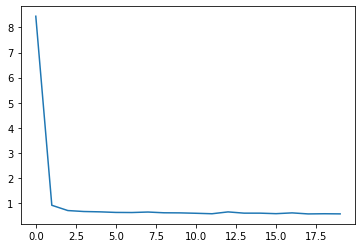

In [26]:
# 確認
plt.plot(train_losses)

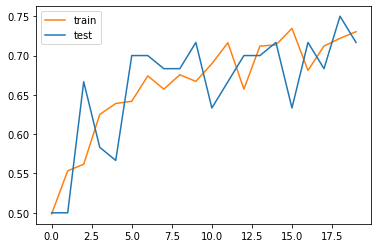

In [27]:
# 確認
# 後半は過学習気味？
plt.plot(train_acc, color="tab:orange", label="train")
plt.plot(val_acc, color="tab:blue", label="test")
plt.legend()